In [ ]:
!pip install pyspark


In [ ]:
import os
os.environ['PYARROW_IGNORE_TIMEZONE'] = '1'
import pandas as pd
import numpy as np
import pyspark.pandas as ps
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col,min,max,mean
import time
from pyspark.sql.functions import col, when, count, sum
import matplotlib.pyplot as plt
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, LongType, DoubleType, TimestampType
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf, count, sum, min, max, mean,countDistinct
from pyspark.sql.types import IntegerType, FloatType
from pyspark.sql.functions import year, month, dayofmonth, hour, datediff, lit





In [8]:


schema = StructType([
    StructField("event_time", TimestampType(), True),
    StructField("event_type", StringType(), True),
    StructField("product_id", IntegerType(), True),
    StructField("category_id", LongType(), True),
    StructField("category_code", StringType(), True),
    StructField("brand", StringType(), True),
    StructField("price", DoubleType(), True),
    StructField("user_id", IntegerType(), True),
    StructField("user_session", StringType(), True)
])


In [9]:


spark = SparkSession.builder \
    .appName("clustering") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "5g") \
    .config("spark.executor.cores", "4") \
    .config("spark.driver.maxResultSize", "2g") \
    .getOrCreate()


In [10]:


## Charger les fichiers CSV avec le schéma défini
octobre_df = spark.read.csv("/home/ghani/Bureau/Data/2019-Oct.csv", header=True, schema=schema)
novembre_df = spark.read.csv("/home/ghani/Bureau/Data/2019-Nov.csv", header=True, schema=schema)
decembre_df = spark.read.csv("/home/ghani/Bureau/Data/2019-Dec.csv", header=True, schema=schema)
janvier_df = spark.read.csv("/home/ghani/Bureau/Data/2020-Jan.csv", header=True, schema=schema)
fevrier_df = spark.read.csv("/home/ghani/Bureau/Data/2020-Feb.csv", header=True, schema=schema)
mars_df = spark.read.csv("/home/ghani/Bureau/Data/2020-Mar.csv", header=True, schema=schema)
avril_df = spark.read.csv("/home/ghani/Bureau/Data/2020-Apr.csv", header=True, schema=schema)




In [11]:
combined_df = (octobre_df
               .union(novembre_df)
               .union(decembre_df)
               .union(janvier_df)
               .union(fevrier_df)
               .union(mars_df)
               .union(avril_df))

# Prendre un échantillon de 10 % du DataFrame combiné
combined_sample = combined_df.sample(withReplacement=False, fraction=0.1, seed=42)






In [12]:
combined_sample.show()
combined_sample.cache()
combined_sample.count()


+-------------------+----------+----------+-------------------+--------------------+---------+-------+---------+--------------------+
|         event_time|event_type|product_id|        category_id|       category_code|    brand|  price|  user_id|        user_session|
+-------------------+----------+----------+-------------------+--------------------+---------+-------+---------+--------------------+
|2019-10-01 02:00:08|      view|  31500053|2053013558031024687|                NULL| luminarc|  41.16|550978835|6280d577-25c8-414...|
|2019-10-01 02:00:18|      view|   1801995|2053013554415534427|electronics.video.tv|    haier| 193.03|537192226|e3151795-c355-4ef...|
|2019-10-01 02:00:19|      view|   1306631|2053013558920217191|  computers.notebook|       hp| 580.89|550050854|7c90fc70-0e80-459...|
|2019-10-01 02:00:37|      view|   1701111|2053013553031414015|computers.periphe...|     acer| 514.79|547028884|3ea7c620-a8d7-45c...|
|2019-10-01 02:00:44|      view|  26500313|2053013563550729061

41176159

In [48]:
combined_sample=spark.read.parquet('/home/ghani/Bureau/Data/combined_sample.parquet')


In [49]:

counts = combined_sample.select([count(col(c)).alias(c) for c in combined_sample.columns])

counts.show()

+----------+----------+----------+-----------+-------------+--------+--------+--------+------------+
|event_time|event_type|product_id|category_id|category_code|   brand|   price| user_id|user_session|
+----------+----------+----------+-----------+-------------+--------+--------+--------+------------+
|  41176159|  41176159|  41176159|   41176159|     34659400|35608309|41176159|41176159|    41176129|
+----------+----------+----------+-----------+-------------+--------+--------+--------+------------+



In [50]:

category_code_distinc = combined_sample.select([countDistinct(col(c)).alias(c) for c in combined_sample.columns])

category_code_distinc.show()



24/06/15 21:58:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/15 21:58:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/15 21:58:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/15 21:58:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/15 21:58:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/15 21:58:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/15 21:58:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/15 21:58:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/15 21:58:12 WARN RowBasedKeyValueBatch: Calling spill() on

24/06/15 22:00:07 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/15 22:00:07 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/15 22:00:07 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/15 22:00:07 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/15 22:00:08 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/15 22:00:08 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/15 22:00:08 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/15 22:00:08 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/15 22:00:17 WARN RowBasedKeyValueBatch: Calling spill() on

+----------+----------+----------+-----------+-------------+-----+------+-------+------------+
|event_time|event_type|product_id|category_id|category_code|brand| price|user_id|user_session|
+----------+----------+----------+-----------+-------------+-----+------+-------+------------+
|  14244974|         3|    330784|       1317|          140| 6141|116978|7531985|    26246458|
+----------+----------+----------+-----------+-------------+-----+------+-------+------------+



In [51]:

counts_null = combined_sample.select([sum(col(c).isNull().cast("int")).alias(c) for c in combined_sample.columns])
counts_null.show()

+----------+----------+----------+-----------+-------------+-------+-----+-------+------------+
|event_time|event_type|product_id|category_id|category_code|  brand|price|user_id|user_session|
+----------+----------+----------+-----------+-------------+-------+-----+-------+------------+
|         0|         0|         0|          0|      6516759|5567850|    0|      0|          30|
+----------+----------+----------+-----------+-------------+-------+-----+-------+------------+



In [52]:

counts_null_brand_category = combined_sample.select(
    sum(when((col("category_code").isNull()) & (col("brand").isNull()), 1).otherwise(0)).alias("null_count")
)
counts_null_brand_category.show()

+----------+
|null_count|
+----------+
|   1534889|
+----------+



In [53]:

event_type_counts = combined_sample.groupBy("event_type").agg(count("*").alias("nombre"))
event_type_counts=event_type_counts.toPandas()
event_type_counts.head()



,event_type,nombre
0,purchase,683963
1,view,38581843
2,cart,1910353


In [54]:
combined_sample.describe(['price']).show()


+-------+-----------------+
|summary|            price|
+-------+-----------------+
|  count|         41176159|
|   mean|285.3748398833914|
| stddev|356.7147870204902|
|    min|              0.0|
|    max|          2574.07|
+-------+-----------------+



In [55]:

purchase_df=combined_sample.filter(col("event_type")=="purchase")
purchase_df.describe(["price"]).show()

+-------+------------------+
|summary|             price|
+-------+------------------+
|  count|            683963|
|   mean| 300.4165978569021|
| stddev|333.85630084472587|
|    min|              0.14|
|    max|           2574.07|
+-------+------------------+



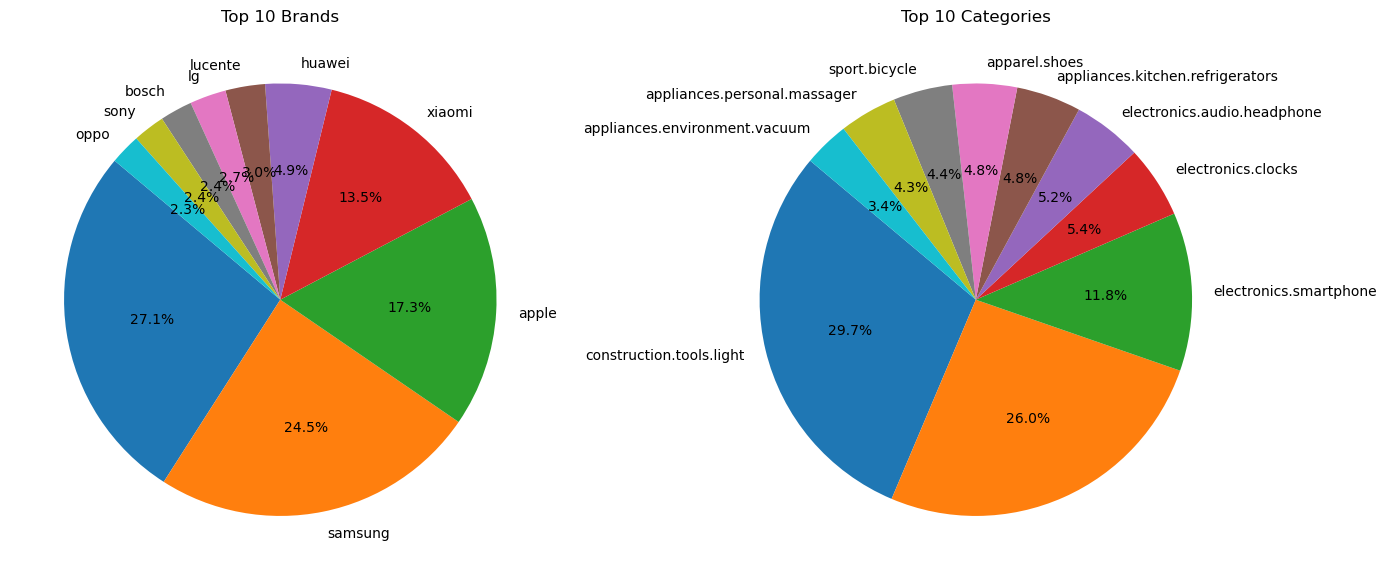

In [56]:
top_brands = combined_sample.groupBy("brand").count().orderBy(col("count").desc()).limit(10)
top_brands_df = top_brands.toPandas()


top_categories = combined_sample.groupBy("category_code").count().orderBy(col("count").desc()).limit(10)
top_categories_df = top_categories.toPandas()


plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.pie(top_brands_df['count'], labels=top_brands_df['brand'], autopct='%1.1f%%', startangle=140)
plt.title('Top 10 Brands')


plt.subplot(1, 2, 2)
plt.pie(top_categories_df['count'], labels=top_categories_df['category_code'], autopct='%1.1f%%', startangle=140)
plt.title('Top 10 Categories')

plt.tight_layout()
plt.show()

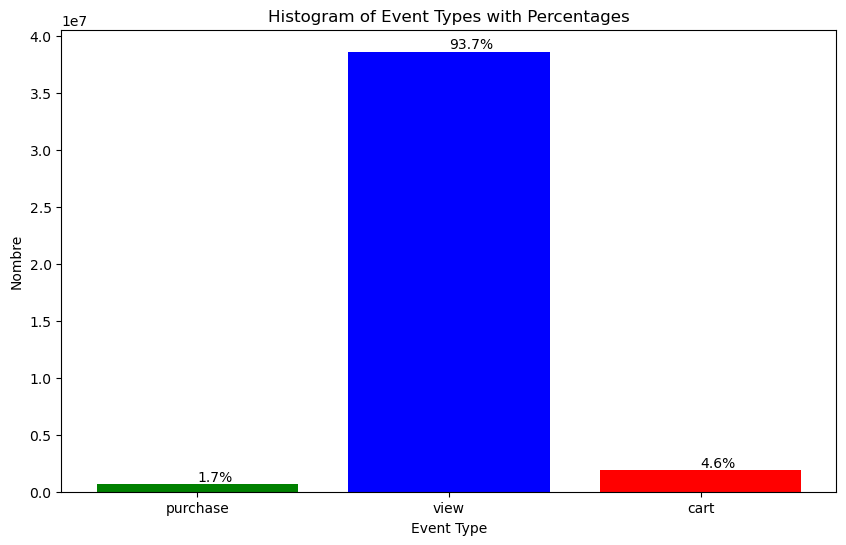

In [23]:

total = event_type_counts['nombre'].sum()
event_type_counts['percentage'] = (event_type_counts['nombre'] / total) * 100


plt.figure(figsize=(10, 6))
bars = plt.bar(event_type_counts['event_type'], event_type_counts['nombre'], color=['green', 'blue', 'red'])


for bar, percentage in zip(bars, event_type_counts['percentage']):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{percentage:.1f}%', va='bottom')  

plt.xlabel('Event Type')
plt.ylabel('Nombre')
plt.title('Histogram of Event Types with Percentages')
plt.show()

In [57]:

combined_sample = combined_sample.filter(~(col("category_code").isNull() & col("brand").isNull()))

combined_sample.show()


+-------------------+----------+----------+-------------------+--------------------+--------+-------+---------+--------------------+
|         event_time|event_type|product_id|        category_id|       category_code|   brand|  price|  user_id|        user_session|
+-------------------+----------+----------+-------------------+--------------------+--------+-------+---------+--------------------+
|2019-11-20 02:53:04|      view|  12200241|2116907525176557699|       sport.bicycle|   giant| 218.54|520693140|54225465-925d-489...|
|2019-11-20 02:53:05|      view|   1480133|2053013561092866779|   computers.desktop|     neo| 787.41|534075025|a0054a33-3074-4d1...|
|2019-11-20 02:53:06|      view|   1002547|2053013555631882655|electronics.smart...|   apple| 495.51|543819199|c711398a-2638-4d6...|
|2019-11-20 02:53:07|      view|  15201325|2053013553484398879|                NULL|gigawatt|  83.12|524804650|d874b582-699f-4b6...|
|2019-11-20 02:53:09|      view|   1005105|2053013555631882655|electr

In [58]:
counts_null_brand_category = combined_sample.select(
    sum(when((col("category_code").isNull()) & (col("brand").isNull()), 1).otherwise(0)).alias("null_count")
)
counts_null_brand_category.show()

+----------+
|null_count|
+----------+
|         0|
+----------+



In [59]:
before=combined_sample.count()
combined_sample = combined_sample.dropDuplicates()
after=combined_sample.count()
print(before-after)

24/06/15 22:03:06 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/15 22:03:06 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/15 22:03:06 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/15 22:03:06 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/15 22:03:06 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/15 22:03:06 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/15 22:03:07 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/15 22:03:07 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/15 22:03:07 WARN RowBasedKeyValueBatch: Calling spill() on

23036


In [64]:
combined_sample = combined_sample.filter((col("user_session").isNotNull()))






In [65]:
counts_null2 = combined_sample.select([sum(col(c).isNull().cast("int")).alias(c) for c in combined_sample.columns])
counts_null2.show()

24/06/15 22:09:44 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/15 22:09:44 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/15 22:09:44 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/15 22:09:44 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/15 22:09:44 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/15 22:09:44 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/15 22:09:44 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/15 22:09:45 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/15 22:09:45 WARN RowBasedKeyValueBatch: Calling spill() on

+----------+----------+----------+-----------+-------------+-------+-----+-------+------------+
|event_time|event_type|product_id|category_id|category_code|  brand|price|user_id|user_session|
+----------+----------+----------+-----------+-------------+-------+-----+-------+------------+
|         0|         0|         0|          0|      4980045|4031313|    0|      0|           0|
+----------+----------+----------+-----------+-------------+-------+-----+-------+------------+



In [66]:
combined_sample=combined_sample.drop("brand")
combined_sample.show(2)

24/06/15 22:11:40 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/15 22:11:40 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/15 22:11:40 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/15 22:11:40 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/15 22:11:40 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/15 22:11:40 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/15 22:11:40 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/15 22:11:40 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/15 22:11:40 WARN RowBasedKeyValueBatch: Calling spill() on

+-------------------+----------+----------+-------------------+--------------------+------+---------+--------------------+
|         event_time|event_type|product_id|        category_id|       category_code| price|  user_id|        user_session|
+-------------------+----------+----------+-------------------+--------------------+------+---------+--------------------+
|2019-11-20 03:08:31|      view|   1004741|2053013555631882655|electronics.smart...|188.42|514470119|b3cf2cdf-f855-421...|
|2019-11-20 03:15:37|      view|   5000476|2053013566100866035|appliances.sewing...|123.53|560316507|37ca13f1-7219-457...|
+-------------------+----------+----------+-------------------+--------------------+------+---------+--------------------+
only showing top 2 rows



In [24]:
combined_sample.write.parquet('/home/ghani/Bureau/Data/combined_sample.parquet')

In [5]:
from pyspark.sql.functions import unix_timestamp, max as spark_max, sum as spark_sum, count as spark_count, col, udf
from pyspark.sql.window import Window
from pyspark.sql.types import IntegerType
import datetime

# Convertir la colonne event_time en timestamp
data = data.withColumn("event_time", unix_timestamp(col("event_time"), "yyyy-MM-dd HH:mm:ss").cast("timestamp"))

# Filtrer les événements d'achat
data_purchase = data.filter(col("event_type") == "purchase")

# Dernière date dans le jeu de données
last_date = data.agg(spark_max("event_time")).collect()[0][0] + datetime.timedelta(days=1)

# Fonction UDF pour calculer la récence
recency_udf = udf(lambda x: (last_date - x).days, IntegerType())

# Calculer RFM
rfm = data_purchase.groupBy("user_id").agg(
    recency_udf(spark_max("event_time")).alias("Recency"),
    spark_count("user_session").alias("Frequency"),
    spark_sum("price").alias("Monetary")
)


data.show(5)



+-------------------+----------+----------+-------------------+--------------------+--------+-------+---------+--------------------+
|         event_time|event_type|product_id|        category_id|       category_code|   brand|  price|  user_id|        user_session|
+-------------------+----------+----------+-------------------+--------------------+--------+-------+---------+--------------------+
|2019-10-01 02:00:00|      view|  44600062|2103807459595387724|                NULL|shiseido|  35.79|541312140|72d76fde-8bb3-4e0...|
|2019-10-01 02:00:00|      view|   3900821|2053013552326770905|appliances.enviro...|    aqua|   33.2|554748717|9333dfbd-b87a-470...|
|2019-10-01 02:00:01|      view|  17200506|2053013559792632471|furniture.living_...|    NULL|  543.1|519107250|566511c2-e2e3-422...|
|2019-10-01 02:00:01|      view|   1307067|2053013558920217191|  computers.notebook|  lenovo| 251.74|550050854|7c90fc70-0e80-459...|
|2019-10-01 02:00:04|      view|   1004237|2053013555631882655|electr

In [6]:
rfm.show(5)

ERROR:root:KeyboardInterrupt while sending command.              (16 + 8) / 428]
Traceback (most recent call last):
  File "/home/ghani/.local/lib/python3.12/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/ghani/.local/lib/python3.12/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/socket.py", line 707, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt


KeyboardInterrupt: 

In [ ]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler

# Préparer les données pour K-means
assembler = VectorAssembler(inputCols=["Recency", "Frequency", "Monetary"], outputCol="features")
rfm_features = assembler.transform(rfm)

# Appliquer K-means
kmeans = KMeans(k=5, seed=1)  # Vous pouvez ajuster le nombre de clusters
model = kmeans.fit(rfm_features)
clusters = model.transform(rfm_features)


centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

# Afficher les premières lignes des clusters
clusters.show(5)


In [ ]:
cluster_analysis = clusters.groupBy("prediction").agg(
    avg("Recency").alias("avg_recency"),
    avg("Frequency").alias("avg_frequency"),
    avg("Monetary").alias("avg_monetary")
)

#import ace_tools as tools; tools.display_dataframe_to_user(name="Analyse des Clusters", dataframe=cluster_analysis)

# Afficher les résultats
cluster_analysis.show()

In [ ]:
spark.stop()